In [1]:
## Packages
from dolfinx.mesh import (create_box, CellType,
                          locate_entities_boundary, meshtags)
from dolfinx.fem import (FunctionSpace, TensorFunctionSpace,
                         VectorFunctionSpace, Function, dirichletbc,
                         locate_dofs_topological, Constant)
from ufl import (FiniteElement, VectorElement, TensorElement,
                 MixedElement, TestFunction, TrialFunction,
                 split, SpatialCoordinate, Measure,
                 Identity, grad, det, inv, tr, exp, ln, inner,
                 dot, as_tensor, as_vector, derivative,
                 sin, cos, outer, variable, transpose, shape,
                 sym, sqrt)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py.PETSc import ScalarType 
from dolfinx.geometry import (BoundingBoxTree,
                              compute_colliding_cells, 
                              compute_collisions)
from mpi4py import MPI

#from dolfiny.projection import project
from dolfiny.invariants import (eigenstate, eigenstate3_legacy)

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
## Useful functions

def project(v, target_func, bcs=[]):
    '''
    This functions is from dolfiny
    I only added the possibility to control the quadrature degree
    '''
    from ufl import (dx, TestFunction, TrialFunction, inner)
    from dolfinx.fem import (form, assemble)
    from dolfinx.fem.petsc import (assemble_matrix, assemble_vector, apply_lifting,
                                   set_bc)
    from petsc4py import PETSc
    
    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    
    metad = {"quadrature_degree": 2} 
    
    dx = dx(V.mesh, metadata=metad)

    # Define variational problem for projection
    w  = TestFunction(V)
    Pv = TrialFunction(V)
    a  = form(inner(Pv, w) * dx)
    L  = form(inner(v, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_func.vector)
    
def plot_mesh(mesh):
    '''
    To plot mesh
    '''
    
    from dolfinx.plot import create_vtk_mesh
    
    try:
        import pyvista
    except ModuleNotFoundError:
        print("pyvista is required for this demo")
        exit(0)

    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        
    # Extract mesh data from dolfin-X (only plot cells owned by the
    # processor) and create a pyvista UnstructuredGrid
    num_cells = mesh.topology.index_map(mesh.topology.dim).size_local
    cell_entities = np.arange(num_cells, dtype=np.int32)
    pyvista_cells = create_vtk_mesh(
        mesh, mesh.topology.dim, cell_entities)
    grid = pyvista.UnstructuredGrid(pyvista_cells[0],pyvista_cells[1], mesh.geometry.x)

    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, style="wireframe", line_width=2, color="black")
    #plotter.view_xy()
    # Save as png if we are using a container with no rendering
    if pyvista.OFF_SCREEN:
        plotter.screenshot("tmp.png")
    else:
        plotter.show()    
    ## -----------------------------------------------        
        
def EVAL(mesh,FUNCT,point):
    '''
    To evaluate a function at a point
    
    FUNCT : Function
    point : point in the body
    '''
    
    # select a point in the mesh in the border between the two processes
    if len(point) == 2:
        rand_global_point = [point[0], point[1], 0.] 
    elif len(point) == 3:
        rand_global_point = [point[0], point[1], point[2]] 

        
    # get bbt for the mesh
    mesh_bbt = BoundingBoxTree(mesh, mesh.topology.dim)

    # convert point in array with one element
    points_list_array = np.array([rand_global_point])
    # for each point, compute a colliding cells and append to the lists
    points_on_proc = []
    cells = []
    cell_candidates = compute_collisions(mesh_bbt, points_list_array)  # get candidates
    colliding_cells = compute_colliding_cells(mesh, cell_candidates, points_list_array)  # get actual
    for i, point in enumerate(points_list_array):
        if len(colliding_cells.links(i)) > 0:
            cc = colliding_cells.links(i)[0]
            points_on_proc.append(point)
            cells.append(cc)
    # convert to numpy array
    points_on_proc = np.array(points_on_proc)
    cells = np.array(cells)
    
    return FUNCT.eval(points_on_proc, cells)
    ## -----------------------------------------------

def ASSIGNt(mesh, A, FUNCT):
    '''
    To assign values from a tuple
    
    FUNCT: Function
    A    : must be a tuple. For example:
    
    scalar "2.0"                    values =   2.0 
    vector "(1.0,2.0)"              values =  (1.0,2.0)       
    tensor "[(1.0,2.0),(3.0,4.0)]"  values =  (1.0,...,4.0)     
    '''
    from dolfiny.projection import project
    
    #return  FUNCT.interpolate(npArray) # alternative
 
    values_ = Constant(mesh, ScalarType(A))  
    
    return project(values_, FUNCT)
    ## -----------------------------------------------

def PythonValue(mesh,A,point):
    '''
    To convert fenicsx values to python values
    
    A    : scalar, vector, or tensor (ufl)
    point: coordinates at which the field is calculated (tuple)
    '''
    from dolfinx.fem import (FunctionSpace, TensorFunctionSpace,
                              VectorFunctionSpace, Function)
    from ufl import (FiniteElement, shape)
    

    if shape(A) == (2,) or shape(A) == (3,):
        fspace    = VectorFunctionSpace(mesh, ("CG",1))
        B         = Function(fspace)
        project(A, B) # A -> B (Coeficcient)
        return EVAL(mesh,B,point)
        
    elif shape(A) == (2,2) or shape(A) == (3,3):
        fspace    = TensorFunctionSpace(mesh, ("DG",1))
        B         = Function(fspace)
        project(A, B) # A -> B (Coeficcient)
        dim = shape(A)[0]
        return np.reshape(EVAL(mesh,B,point),[dim,dim])
    else:
        element   = FiniteElement("CG", mesh.ufl_cell(), 1)
        fspace    = FunctionSpace(mesh, element) 
        B         = Function(fspace)
        # when A is not coefficient
        if type(A) != type(B):
            project(A, B) # A -> B (Coeficcient)
            return EVAL(mesh,B,point)[0]
        # when A is already a Coefficient class:
        else: 
            return EVAL(mesh,A,point)[0]
    ## -----------------------------------------------
    
def eigenValues(T, tol=1e-9):
    dim=T.geometric_dimension()                                                 # get geometric dimension of tensor T to decide which subroutine to use for eigenvalue computations

    # choose projection tensor routine based on dimensionality of problem
    if dim == 2:                                                                # 2D-problem
        return _eigVal2D(T,tol)
    else:                                                                       # 3D-problem
        return _eigVal3D(T,tol)

def _eigVal3D(T, tol):                                                           # dolfin module
    from ufl import (tr, inner, det, conditional, sign, lt,
                     atan_2, sqrt, cos, sin)                                                                      # ufl module
    import numpy as np                                                              # numpy
    import copy as cp 

    # determine perturbation from tolerance
    pert = 2*tol

    # get required invariants
    I1 = tr(T)                                                               # trace of tensor
    I2 = 0.5*(tr(T)**2-inner(T,T))                                        # 2nd invariant of tensor
    I3 = det(T)                                                              # determinant of tensor

    p = I1**2 - 3*I2                                                            # preliminary value for p
    p = conditional(lt(p,tol),abs(p)+pert,p)                            # add numerical perturbation to p, if close to zero; ensure positiveness of p
    q = 27/2*I3 + I1**3 - 9/2*I1*I2                                             # preliminary value for q
    q = conditional(lt(abs(q),tol),q+sign(q)*pert,q)                # add numerical perturbation (with sign) to value of q, if close to zero

    # determine angle phi for calculation of roots
    phiNom2 =  27*( 1/4*I2**2*(p-I2) + I3*(27/4*I3-q) )                         # preliminary value for squared nominator of expression for angle phi
    phiNom2 = conditional(lt(phiNom2,tol),abs(phiNom2)+pert,phiNom2)    # add numerical perturbation to ensure non-zero nominator expression for angle phi
    phi = 1/3*atan_2(sqrt(phiNom2),q)                                   # calculate angle phi

    # calculate polynomial roots
    lambda1 = 1/3*(sqrt(p)*2*cos(phi)+I1)
    lambda2 = 1/3*(-sqrt(p)*(cos(phi)+sqrt(3)*sin(phi))+I1)
    lambda3 = 1/3*(-sqrt(p)*(cos(phi)-sqrt(3)*sin(phi))+I1)

    # return polynomial roots (eigenvalues)
    return lambda1, lambda2, lambda3

def projectionTensors(T, *eigenValues):
    dim=T.geometric_dimension()                                                 # get geometric dimension of tensor T to decide which subroutine to use for projection tensor computations

    # choose projection tensor routine based on dimensionality of problem
    if dim == 2:                                                                # 2D-problem
        return _projTen2D(T,*eigenValues)
    else:                                                                       # 3D-problem
        return _projTen3D(T,*eigenValues)

def _projTen3D(T, lambda1, lambda2, lambda3):
    import ufl                                                                      # ufl module

    # get required quantities
    I = ufl.Identity(3)

    # calculate the individual projection tensors
    M1 = (T-lambda2*I)*(T-lambda3*I)/((lambda1-lambda2)*(lambda1-lambda3))
    M2 = (T-lambda3*I)*(T-lambda1*I)/((lambda2-lambda3)*(lambda2-lambda1))
    M3 = (T-lambda1*I)*(T-lambda2*I)/((lambda3-lambda1)*(lambda3-lambda2))

    # return projection tensors
    return M1, M2, M3

In [3]:
## Mesh
comm = MPI.COMM_WORLD

dimx, dimy , dimz = 1, 0.5, 1
nx, ny, nz = 1, 1, 1

mesh = create_box(comm,[[0.,0.,0.],[dimx,dimy,dimz]],[nx,ny,nz],CellType.hexahedron)

gdim = mesh.geometry.dim # geometry dimension
tdim = mesh.topology.dim # topology dimension
fdim = tdim - 1          # facet dimension


In [4]:
## Facets identification

left   = lambda x: np.isclose(x[0], 0)
right  = lambda x: np.isclose(x[0], dimx)
bottom = lambda x: np.isclose(x[1], 0)
top    = lambda x: np.isclose(x[1], dimy)
back   = lambda x: np.isclose(x[2], 0)
front  = lambda x: np.isclose(x[2], dimz)

left_facets   = locate_entities_boundary(mesh, fdim, left)
right_facets  = locate_entities_boundary(mesh, fdim, right)
bottom_facets = locate_entities_boundary(mesh, fdim, bottom)
top_facets    = locate_entities_boundary(mesh, fdim, top)
back_facets   = locate_entities_boundary(mesh, fdim, back)
front_facets  = locate_entities_boundary(mesh, fdim, front)


marked_facets = np.hstack([left_facets, right_facets,
                           bottom_facets, top_facets,
                           back_facets, front_facets])

marked_values = np.hstack([np.full_like(left_facets,   1),
                           np.full_like(right_facets,  2),
                           np.full_like(bottom_facets, 3),
                           np.full_like(top_facets,    4),
                           np.full_like(back_facets,   5),
                           np.full_like(front_facets,  6)])

sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

In [5]:
## Integration
metadata = {"quadrature_degree": 2}
ds = Measure('ds', domain=mesh, subdomain_data=facet_tag, metadata=metadata)
dx = Measure("dx", domain=mesh, metadata=metadata)

In [6]:
## Approximation space
W     = VectorFunctionSpace(mesh, ("CG",1))
u     = Function(W) 
u_    = TestFunction(W)
du    = TrialFunction(W)  

u_old = Function(W)

# Scalar space
fe    = FiniteElement("CG", mesh.ufl_cell(), 1)   
ET0   = FunctionSpace(mesh, fe)   
# Vector space
ET1   = VectorFunctionSpace(mesh, ("CG", 1))
# Tensor space
ET2   = TensorFunctionSpace(mesh, ("DG",0))

In [7]:
## Material parameters
tau1, tau2   = 1.0   , 1.0
beta1, beta2 = 1.0   , 1.0  #0.000001
k, c         = 1e6   , 0.877   #[kPa,kPa] 
k1, k2       = 0.154 , 34.157  #[kPa,-] 
tau1, tau2   = 1.0    , 1.0

dt = 0.1 # [s]

In [8]:
## Fibers definition
theta  = np.radians(0.0)
a0     = as_vector([cos(theta),sin(theta),0]) 
A0     = outer(a0,a0)                       

In [9]:
## Internal variables
bMe      = Function(ET2) # bᵐₑ
invCMv   = Function(ET2) # (Cᵐᵥ)⁻¹ 
lamFv    = Function(ET0) # λᶠᵥ

I4e_  = Function(ET0) # Ī₄ₑ
Ie_   = Function(ET0) # Īₑ

In [10]:
## Initial Values

Ituple = ((1.0,0.0,0.0),(0.0,1.0,0.0),(0.0,0.0,1.0))

# Displacement
ASSIGNt(mesh,(0.,0.,0.),u) 

## Matrix viscoelasticity internal variable
# [bᵐₑ]₀  = I
ASSIGNt(mesh, Ituple, bMe)
# Stretches
lamM1e = 1.0 # [λᵐ₁ₑ]₀ = 1
lamM2e = 1.0 # [λᵐ₂ₑ]₀ = 1
lamM3e = 1.0 # [λᵐ₃ₑ]₀ = 1
eps1e  = 0.0
eps2e  = 0.0
eps3e  = 0.0
# [(Cᵐᵥ)⁻¹]₀  = I
ASSIGNt(mesh,Ituple,invCMv)
# [Īₑ]ⁿ⁺¹  = 3    
ASSIGNt(mesh,3.0,Ie_)  

## Fibers viscoelasticity internal variable
# [λᶠᵥ]₀   = 1 
ASSIGNt(mesh,1.0,lamFv)      
# [Ī₄ₑ]ⁿ⁺¹ = 1
ASSIGNt(mesh,1.0,I4e_)    

In [11]:
# estoy viendo la forma de sacar el python value de los escalares
# hay problemas con los que ya son coefficient
# intento condicionar la subclase del escalar
# vectores y tensores trabajan bien

In [12]:
def MatrixEvolution(F,invCMv,eps0):
    """
    eps0  = ln[λᵐ₁ₑ]ₙ₋₁  (initial guest)
    invCMv = [Cᵐᵥ]ₙ₋₁    
    """
    ## Kinematics
    J   = det(F)

    print("Solving Matrix viscoelasticity...")
    
    ## Elastic predictor
    bMe_trial    = F*invCMv*F.T # [(bᵐₑ)ₜᵣᵢₐₗ]ₙ = [F]ₙ[Cᵐᵥ⁻¹]ₙ₋₁[F]ₙᵀ
    
    # with dolfiniy eigen values (not the best results)
    #lamMe2_trial, lamMe2_trial_proj  = eigenstate3_legacy(bMe_trial)#eigenstate(bMe_trial)
    #lamMe_trial1 , lamMe_trial2 ,  lamMe_trial3   = sqrt(lamMe2_trial[0]), sqrt(lamMe2_trial[1]),  sqrt(lamMe2_trial[2])
    
    # with functions
    lamMe2_trial1, lamMe2_trial2,  lamMe2_trial3  = eigenValues(bMe_trial)
    lamMe_trial1 , lamMe_trial2 ,  lamMe_trial3   = sqrt(lamMe2_trial1), sqrt(lamMe2_trial2),  sqrt(lamMe2_trial3)

    
    ## Python values (these are scalars so the point to be evaluated is irrelevant)
    
    JJ       = PythonValue(mesh,J,(0,0,0))
    l1trial  = PythonValue(mesh,ln(lamMe_trial1),(0,0,0))
    l2trial  = PythonValue(mesh,ln(lamMe_trial2),(0,0,0))
    l3trial  = PythonValue(mesh,ln(lamMe_trial3),(0,0,0))
    epsTrial = [l1trial, l2trial, l3trial]

    print("eps trial:",epsTrial)

    ## Inelastic corrector

    mu    = 2.*c
    alpha = 2. # neo-hookean
    etaD  = 1.5

    def rA(eps):
        r1 = eps[0] + mu*dt*1/(2*etaD)*( 2/3*JJ**(-2/3)*np.exp(2.*eps[0]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[1]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[2]) ) - epsTrial[0]
        r2 = eps[1] + mu*dt*1/(2*etaD)*( 2/3*JJ**(-2/3)*np.exp(2.*eps[1]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[0]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[2]) ) - epsTrial[1]
        r3 = eps[2] + mu*dt*1/(2*etaD)*( 2/3*JJ**(-2/3)*np.exp(2.*eps[2]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[0]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[1]) ) - epsTrial[2]
        r  = [r1,
              r2,
              r3] 
        return r # 3x1

    def Kab(eps):
        dr1d1 = 1. + dt*1/(2*etaD)*(mu*alpha)*( 4/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr1d2 = 1. + dt*1/(2*etaD)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[0]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr1d3 = 1. + dt*1/(2*etaD)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[0]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[2]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) )

        dr2d1 = 1. + dt*1/(2*etaD)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[1]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr2d2 = 1. + dt*1/(2*etaD)*(mu*alpha)*( 4/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr2d3 = 1. + dt*1/(2*etaD)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[1]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[2]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) )  

        dr3d1 = 1. + dt*1/(2*etaD)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[2]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) )
        dr3d2 = 1. + dt*1/(2*etaD)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[2]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) )
        dr3d3 = 1. + dt*1/(2*etaD)*(mu*alpha)*( 4/9*JJ**(-2/3)*np.exp(2.*eps[2]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) )

        Jab = [[dr1d1,dr1d2,dr1d3],
               [dr2d1,dr2d2,dr2d3],
               [dr3d1,dr3d2,dr3d3]]
               
        return Jab # 3x3

    # Initial guest, from the previous iteration
    EPSk0 = [eps0[0],eps0[1],eps0[2]]
    
    print('Initial eps:\n',EPSk0)

    from scipy.optimize import fsolve
    EPSk = fsolve(rA, EPSk0, fprime=Kab)
    
    print('Predicted eps:\n',EPSk)
    print('Residual: \n',rA(EPSk))
    
    ## FEniCS
    eps    = [EPSk[0]          , EPSk[1]          , EPSk[2]          ]   # [ε₁ₑ]ₙ      , [ε₂ₑ]ₙ   , [ε₂₃]ₙ 
    lamMe  = [np.exp(eps[0])   , np.exp(eps[1])   , np.exp(eps[2])   ]   # [λᵐ₁ₑ]ₙ     , [λᵐ₂ₑ]ₙ     principal stretches

    ## Eigen-basis nᵢ⊗nᵢ
    
    # with dolfiniy eigenvalues (not the best results)
    #nxn = lamMe2_trial_proj

    # with functions
    n1xn1, n2xn2, n3xn3  = projectionTensors(bMe_trial, lamMe2_trial1, lamMe2_trial2, lamMe2_trial3) 
    nxn = [n1xn1, n2xn2, n3xn3]

    print('Internal variable updated')

    return lamMe, nxn, eps

In [13]:
def FiberEvolution(F,lamFv0):
    from scipy import optimize
    #### Kinematics
    J   = det(F)
    F_  = J**(-1/3)*F
    C_  = F_.T*F_
    I4_ = inner(C_,A0)

    ## Python values
    I4iso     = PythonValue(mesh,I4_,(0,0,0))
    stretchF0 = PythonValue(mesh,lamFv0,(0,0,0))
    
    etaF = 1.5   

    def tauFneq(stretchF):
        I4eiso = I4iso/(stretchF**2)
        return 2*beta2*k1*exp(k2*(I4eiso-1.)**2)*(I4eiso-1.)*I4eiso

    def dTauxI4e(stretchF):
        I4eiso = I4iso/(stretchF**2)
        dTauxI4e = 2*beta2*k1*exp(k2*(I4eiso-1.)**2)*( 2*k2*(I4eiso-1)**2*I4eiso + (I4eiso - 1) + I4eiso )*I4eiso
        return dTauxI4e

    def rA(stretchF):
        return stretchF - dt/etaF * tauFneq(stretchF) * stretchF - stretchF0

    def Jij(stretchF):
        return 1. - dt/etaF*(tauFneq(stretchF) - 2*dTauxI4e(stretchF))
    
    
    lamFV = optimize.newton(rA, stretchF0, fprime=Jij,tol=1e-6,maxiter=100)

    
    print('predicted fiber stretch:', lamFV)
    print('residual fiber:',rA(lamFV))

    # print('--------------- --------------- ---------------')

    return lamFV

In [14]:
def PK2(F,invCMv,I4e_):

    ## Kinematics
    J   = det(F)
    C   = F.T*F
    F_  = J**(-1/3)*F
    C_  = F_.T*F_
    
    ## Matrix
    I1    = tr(C) 
    sMeq  = 2*c*(J**(-2/3))*(I-1/3*I1*inv(C))
    sMneq = 2*beta1*c*(J**(-2/3))*(invCMv-1/3*inner(C,invCMv)*inv(C)) # Ie = inner(C,invCMv)
    sVol  = k*(J**2-J)*inv(C)

    ## Fiber
    I4_   = inner(C_,A0)  # Pure elastic response
    #I4v  = lamFv**2      # Viscous response
    #I4e_ = I4_/I4v       # Relaxing elastic response
    sFeq  = 2.*k1*(I4_-1.)*exp(k2*(I4_-1.)**2)*(J**(-2/3))*I4_*(A0/I4_-1/3*inv(C_))
    sFneq = 2.*beta2*k1*(I4e_-1.)*exp(k2*(I4e_-1.)**2)*(J**(-2/3))*I4e_*(A0/I4_-1/3*inv(C_))
    
    return sMeq, sMneq, sVol, sFeq, sFneq

In [15]:
## Dirichlet BC
left_dofs    = locate_dofs_topological(W.sub(0), fdim, left_facets)
right_dofs   = locate_dofs_topological(W.sub(0), fdim, right_facets)
bottom_dofs  = locate_dofs_topological(W.sub(1), fdim, bottom_facets)
top_dofs     = locate_dofs_topological(W.sub(1), fdim, top_facets)
back_dofs    = locate_dofs_topological(W.sub(2), fdim, back_facets)
front_dofs   = locate_dofs_topological(W.sub(2), fdim, front_facets)

# displacement imposed, is updated with disp.value = #!&
disp = Constant(mesh,ScalarType(0.0))

bcs  = [
        dirichletbc(ScalarType(0.0), left_dofs, W.sub(0)),
        dirichletbc(ScalarType(0.0), bottom_dofs, W.sub(1)),
        dirichletbc(ScalarType(0.0), back_dofs, W.sub(2)),
        dirichletbc(disp, right_dofs, W.sub(0)),
        dirichletbc(disp, front_dofs, W.sub(2))
       ]

In [16]:
## Neumann BC
B = Constant(mesh, ScalarType((0.0, 0.0, 0.0)))
T = Constant(mesh, ScalarType((0.0, 0.0, 0.0)))

In [17]:
## kinematics
I  = Identity(u.geometric_dimension())   # Identity tensor
F  = variable(I + grad(u))               # [Variable][Coefficient]
J  = det(F)
C  = F.T*F
C_ = J**(-2/3)*C
I4 = inner(C,A0)

In [18]:
## Weak form - variational problem
#mech    = inner(PK2(F,invCMv,I4e_),sym(F.T*grad(u_)))*dx

sMeq, sMneq, sVol, sFeq, sFneq = PK2(F,invCMv,I4e_)
PiolaKirchhoff2 = sMeq + sMneq + sVol + sFeq + sFneq
PiolaKirchhoff1 = F*PiolaKirchhoff2


mech    = inner(PiolaKirchhoff1,grad(u_))*dx
Jac     = derivative(mech, u, du) 
problem = NonlinearProblem(mech, u, bcs=bcs, J=Jac)
solver  = NewtonSolver(mesh.comm, problem)


solver.atol=1.e-8
solver.rtol=1.e-4
solver.convergence_criterion='incremental'
solver.max_it=500
solver.report=True

In [19]:
## Iteration setup
tTotal =  3
Nsteps = int(tTotal/dt+1)
Time   = np.linspace(0, tTotal, Nsteps)
j      = 1

ufinal = 0.1
d_rate = dimx*ufinal


px = (dimx,dimy/2,dimz/2)
pz = (dimx/2,dimy/2,dimz)
pt = px

## Storage
disp_v        = np.zeros((Nsteps,1))
SIG_v         = np.zeros((Nsteps,1))
SIGeq_v       = np.zeros((Nsteps,1))
SIGneq_v      = np.zeros((Nsteps,1))
invariants    = np.zeros((Nsteps,4))

In [20]:
## Simulation
startTime = datetime.now()

print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

# ---------------------------------------------------- #
for i, d in enumerate(Time):

    print("Iteration n=", i)
    print("Time: ",d,"[s]") # [s]

    # ~~~~~~ Relaxation control ~~~~~~ #
    if Time[i] <= 1:
        disp.value  = d_rate*d
    else:
        disp.value  = d_rate*Time[i-j]
        j += 1


    # ~~~~~~ Solve FEM ~~~~~~ #
    solver.solve(u)

    disp_v[i] = PythonValue(mesh,u,pt)[0]

    # ~~~~~~ Matrix internal variable update ~~~~~~ #
    eps = [eps1e, eps2e, eps3e] 

    lamMe , nxn, epsi  = MatrixEvolution(F,invCMv,eps) # [λᵐₐ]ₙ , [(λᵐₐ)²]ₙ , [𝜏ₐ]ₙ , [ln(λᵐₐₑ)]ₙ

    ## Principal stretches
    lamM1e = lamMe[0] # [λᵐ₁ₑ]ₙ
    lamM2e = lamMe[1] # [λᵐ₂ₑ]ₙ
    lamM3e = lamMe[2] # [λᵐ₃ₑ]ₙ
        
    eps1e = epsi[0]
    eps2e = epsi[1]
    eps3e = epsi[2]
    
    ## Left Cauchy-Green strain [bᵐₑ]ₙ = Σ(λᵐₐ)²nₐ⊗nₐ
    bM_e  = lamM1e**2*nxn[0] +\
            lamM2e**2*nxn[1] +\
            lamM3e**2*nxn[2]
    project(bM_e,bMe) # bM_e -> bMe

    ## [(Cᵐᵥ)⁻¹]ₙ = [F⁻¹]ₙ[bᵐₑ]ₙ[F⁻ᵀ]ₙ
    inv_CMv = inv(F)*bMe*inv(F.T)
    project(inv_CMv,invCMv) # inv_CMv -> invCMv

    Ie  = inner(C,invCMv)
    Ie_ = inner(C_,invCMv)


    # ~~~~~~ Fiber internal variable update ~~~~~~ #
    # uso lamF_v  = [λᶠᵥ]ₙ₋₁ initial guest
    
    # Fiber viscous stretch
    lamF_v = FiberEvolution(F,lamFv)
    project(lamF_v,lamFv) # lamF_v -> lamFv
 
    # Pseudo-invariants
    I4      = inner(C,A0)
    I4v     = lamFv**2
    I4_     = J**(-2/3)*I4
    I4_e_   = I4_/I4v
    project(I4_e_,I4e_) # I4_e_ -> I4e_

    # ~~~ Cauchy Stress for analysis ~~~ #
    SIG_v[i]    = PythonValue(mesh,inv(J)*F*PiolaKirchhoff2*F.T,pt)[0][0]
    SIGeq_v[i]  = PythonValue(mesh,inv(J)*F*(sMeq  + sVol + sFeq)*F.T,pt)[0][0]
    SIGneq_v[i] = PythonValue(mesh,inv(J)*F*(sMneq + sFneq)*F.T,pt)[0][0]
    
    # Pseudo-invariants
    I4      = inner(C,A0)
    I4v     = lamFv**2
    I4_     = J**(-2/3)*I4
    I4_e_   = I4_/I4v
    project(I4_e_,I4e_) # I4_e_ -> I4e_

    # ~~~ Cauchy Stress for analysis ~~~ #
    SIG_v[i]    = PythonValue(mesh,inv(J)*F*PiolaKirchhoff2*F.T,pt)[0][0]
    SIGeq_v[i]  = PythonValue(mesh,inv(J)*F*(sMeq  + sVol + sFeq)*F.T,pt)[0][0]
    SIGneq_v[i] = PythonValue(mesh,inv(J)*F*(sMneq + sFneq)*F.T,pt)[0][0]

    # ~~~ Cauchy Stress for analysis ~~~ #
    invariants[i,0] = PythonValue(mesh,tr(C_),pt) # I1 iso
    invariants[i,1] = PythonValue(mesh,Ie_,pt)    # Ie iso
    invariants[i,2] = PythonValue(mesh,I4_,pt)    # I4 iso
    invariants[i,3] = PythonValue(mesh,I4e_,pt)   # I4e iso

    # ~~~ Save values of current displacement ~~~ #
    u_old.x.array[:] = u.x.array
# ---------------------------------------------------- #

endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Iteration n= 0
Time:  0.0 [s]
Solving Matrix viscoelasticity...
eps trial: [1.2909777823445741e-05, -1.2910111157125991e-05, -2.220446049250315e-16]
Initial eps:
 [0.0, 0.0, 0.0]
Predicted eps:
 [ 1.15582186e-05 -1.15585496e-05 -2.30834762e-12]
Residual: 
 [-3.2187251995663413e-19, -3.2187251995663413e-19, 6.44801391964858e-19]
Internal variable updated
predicted fiber stretch: 1.0000000000000033
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 1
Time:  0.1 [s]
Solving Matrix viscoelasticity...
eps trial: [0.011112337635861919, -0.019848780590590507, 0.008736756550188515]
Initial eps:
 [1.155821859604788e-05, -1.1558549621602557e-05, -2.308347615884578e-12]
Predicted eps:
 [ 0.00995508 -0.01778696  0.00783219]
Residual: 
 [-3.469446951953614e-18, 0.0, 6.938893903907228e-18]
Internal variable updated
predicted fiber stretch: 1.000408548066485
residual fiber: -6.661338147750939e-16
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 2
Time:  0.2 [s]
Solving Matrix viscoelasticity...
eps trial: [0.01910673336128008, -0.03753549384125854, 0.01842906800249477]
Initial eps:
 [0.009955082079004704, -0.01778696113487827, 0.007832192651333494]
Predicted eps:
 [ 0.01713402 -0.03366318  0.01652947]
Residual: 
 [1.5543122344752192e-15, 1.547373340571312e-15, 1.5404344466674047e-15]
Internal variable updated
predicted fiber stretch: 1.0012552148160632
residual fiber: -6.661338147750939e-14
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 3
Time:  0.30000000000000004 [s]
Solving Matrix viscoelasticity...
eps trial: [0.026757495594272544, -0.053177131100271884, 0.026420049701074613]
Initial eps:
 [0.017134021207864128, -0.03366318215310415, 0.01652946846776097]
Predicted eps:
 [ 0.02401228 -0.04772357  0.0237117 ]
Residual: 
 [-2.1510571102112408e-16, -2.1510571102112408e-16, -2.1163626406917047e-16]
Internal variable updated
predicted fiber stretch: 1.0025925458280138
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 4
Time:  0.4 [s]
Solving Matrix viscoelasticity...
eps trial: [0.033630037925174, -0.0670475313262787, 0.03341801905475513]
Initial eps:
 [0.024012280591525114, -0.0477235669731022, 0.023711700576651718]
Predicted eps:
 [ 0.03019797 -0.06020681  0.03000937]
Residual: 
 [0.0, 2.7755575615628914e-17, 2.0816681711721685e-17]
Internal variable updated
predicted fiber stretch: 1.00449100953444
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 5
Time:  0.5 [s]
Solving Matrix viscoelasticity...
eps trial: [0.039748745871497446, -0.07934567310349232, 0.039597561479096856]
Initial eps:
 [0.030197967966543313, -0.060206813236542034, 0.030009370923649192]
Predicted eps:
 [ 0.03571069 -0.07128643  0.03557637]
Residual: 
 [2.7755575615628914e-17, 2.7755575615628914e-17, 3.469446951953614e-17]
Internal variable updated
predicted fiber stretch: 1.0070307859213405
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 6
Time:  0.6000000000000001 [s]
Solving Matrix viscoelasticity...
eps trial: [0.04518064278113868, -0.09024383827557873, 0.04506393534598736]
Initial eps:
 [0.035710692120074945, -0.07128643232937383, 0.03557637445640095]
Predicted eps:
 [ 0.04060887 -0.08111344  0.0405053 ]
Residual: 
 [5.551115123125783e-17, 4.163336342344337e-17, 4.163336342344337e-17]
Internal variable updated
predicted fiber stretch: 1.0102893370738442
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 7
Time:  0.7000000000000001 [s]
Solving Matrix viscoelasticity...
eps trial: [0.04999439748199163, -0.09989282398744313, 0.04989927041148648]
Initial eps:
 [0.04060887499510173, -0.08111343715783816, 0.040505302014283866]
Predicted eps:
 [ 0.0449529  -0.08982062  0.04486856]
Residual: 
 [4.85722573273506e-17, 4.163336342344337e-17, 5.551115123125783e-17]
Internal variable updated
predicted fiber stretch: 1.0143259440994887
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 8
Time:  0.8 [s]
Solving Matrix viscoelasticity...
eps trial: [0.05425344265957972, -0.10842530527800724, 0.05417281144753919]
Initial eps:
 [0.04495290104905637, -0.08982061989082848, 0.04486856274780725]
Predicted eps:
 [ 0.04879883 -0.09752528  0.0487274 ]
Residual: 
 [4.85722573273506e-17, 4.163336342344337e-17, 4.85722573273506e-17]
Internal variable updated
predicted fiber stretch: 1.0191672054825724
residual fiber: -1.7763568394002505e-15
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 9
Time:  0.9 [s]
Solving Matrix viscoelasticity...
eps trial: [0.058014974347248734, -0.11595848473103182, 0.057944568840456526]
Initial eps:
 [0.048798827074825114, -0.09752528149305185, 0.04872740324733855]
Predicted eps:
 [ 0.05219739 -0.1043314   0.05213507]
Residual: 
 [4.85722573273506e-17, 4.163336342344337e-17, 4.163336342344337e-17]
Internal variable updated
predicted fiber stretch: 1.0247988051600156
residual fiber: -1.9761969838327786e-14
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 10
Time:  1.0 [s]
Solving Matrix viscoelasticity...
eps trial: [0.06133017140544458, -0.12259624884851089, 0.06126725664349848]
Initial eps:
 [0.052197388317925274, -0.10433140096853219, 0.05213507110728049]
Predicted eps:
 [ 0.05519412 -0.11033142  0.05513847]
Residual: 
 [2.0816681711721685e-17, 2.7755575615628914e-17, 3.469446951953614e-17]
Internal variable updated
predicted fiber stretch: 1.0311668991289296
residual fiber: -1.3700152123874432e-13
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 11
Time:  1.1 [s]
Solving Matrix viscoelasticity...
eps trial: [0.055205217844911766, -0.11033144739960267, 0.05512737366780633]
Initial eps:
 [0.05519412309878668, -0.11033141845633816, 0.055138474557983735]
Predicted eps:
 [ 0.0496586  -0.09924711  0.04958966]
Residual: 
 [2.060851489460447e-15, 2.095545958979983e-15, 2.067790383364354e-15]
Internal variable updated
predicted fiber stretch: 1.036404152620453
residual fiber: -4.884981308350689e-15
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 12
Time:  1.2000000000000002 [s]
Solving Matrix viscoelasticity...
eps trial: [0.049672310084209116, -0.09924714448649408, 0.049575937963433445]
Initial eps:
 [0.04965859985018867, -0.09924711410685473, 0.04958965836978771]
Predicted eps:
 [ 0.04466216 -0.08923776  0.04457671]
Residual: 
 [1.3877787807814457e-17, 0.0, 1.3877787807814457e-17]
Internal variable updated
predicted fiber stretch: 1.0408529300051197
residual fiber: -2.220446049250313e-16
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 13
Time:  1.3 [s]
Solving Matrix viscoelasticity...
eps trial: [0.044679112037147146, -0.08923778355407498, 0.0445597395817029]
Initial eps:
 [0.04466215815568245, -0.0892377649592292, 0.04457671036469525]
Predicted eps:
 [ 0.04015647 -0.08020592  0.04005052]
Residual: 
 [1.3877787807814457e-17, 1.3877787807814457e-17, 1.3877787807814457e-17]
Internal variable updated
predicted fiber stretch: 1.0447187313007533
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 14
Time:  1.4000000000000001 [s]
Solving Matrix viscoelasticity...
eps trial: [0.040177446560888994, -0.08020592423058921, 0.040029514424871904]
Initial eps:
 [0.04015646902416709, -0.08020592109368495, 0.04005052013429297]
Predicted eps:
 [ 0.03609714 -0.07206183  0.03596572]
Residual: 
 [4.163336342344337e-17, 4.163336342344337e-17, 3.469446951953614e-17]
Internal variable updated
predicted fiber stretch: 1.0481345840690954
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 15
Time:  1.5 [s]
Solving Matrix viscoelasticity...
eps trial: [0.036123125319405085, -0.0720618066248544, 0.03593969043376315]
Initial eps:
 [0.0360971398828685, -0.0720618261434188, 0.0359657230157221]
Predicted eps:
 [ 0.03244354 -0.06472298  0.03228045]
Residual: 
 [2.7755575615628914e-17, 4.163336342344337e-17, 1.3877787807814457e-17]
Internal variable updated
predicted fiber stretch: 1.0511916084332187
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 16
Time:  1.6 [s]
Solving Matrix viscoelasticity...
eps trial: [0.032475735880836305, -0.06472292454250038, 0.032248173544913626]
Initial eps:
 [0.03244353887675963, -0.0647229794330124, 0.0322804496845667]
Predicted eps:
 [ 0.02915858 -0.05811371  0.02895611]
Residual: 
 [1.3877787807814457e-17, 1.3877787807814457e-17, 1.3877787807814457e-17]
Internal variable updated
predicted fiber stretch: 1.053955018611296
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 17
Time:  1.7000000000000002 [s]
Solving Matrix viscoelasticity...
eps trial: [0.029198497763594806, -0.05811359545102179, 0.028916061543179983]
Initial eps:
 [0.0291585813492946, -0.0581137076370959, 0.028956111171050892]
Predicted eps:
 [ 0.02620858 -0.05216474  0.02595712]
Residual: 
 [0.0, 1.3877787807814457e-17, 1.0408340855860843e-17]
Internal variable updated
predicted fiber stretch: 1.056473153562311
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 18
Time:  1.8 [s]
Solving Matrix viscoelasticity...
eps trial: [0.02625808829954909, -0.05216452900731404, 0.025907386715516283]
Initial eps:
 [0.02620857887561704, -0.05216473604332332, 0.0259571210234593]
Predicted eps:
 [ 0.02356306 -0.04681276  0.02325064]
Residual: 
 [3.469446951953614e-18, 0.0, 3.469446951953614e-18]
Internal variable updated
predicted fiber stretch: 1.058782885902387
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 19
Time:  1.9000000000000001 [s]
Solving Matrix viscoelasticity...
eps trial: [0.023624463974896825, -0.04681239606914285, 0.02318886352617567]
Initial eps:
 [0.023563063272764365, -0.046812761945955676, 0.02325064468094265]
Predicted eps:
 [ 0.02119461 -0.04200003  0.02080636]
Residual: 
 [0.0, 2.0816681711721685e-17, -3.469446951953614e-18]
Internal variable updated
predicted fiber stretch: 1.060913021897464
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 20
Time:  2.0 [s]
Solving Matrix viscoelasticity...
eps trial: [0.021270801560551035, -0.04199939801313032, 0.020729516826288527]
Initial eps:
 [0.021194608535003663, -0.04200003235660951, 0.020806355253535507]
Predicted eps:
 [ 0.01907876 -0.03767393  0.01859608]
Residual: 
 [-6.938893903907228e-18, 6.938893903907228e-18, 6.938893903907228e-18]
Internal variable updated
predicted fiber stretch: 1.0628865259006026
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 21
Time:  2.1 [s]
Solving Matrix viscoelasticity...
eps trial: [0.019173246619402, -0.03767283647561125, 0.018500503144661676]
Initial eps:
 [0.019078761588654687, -0.03767392601300809, 0.018596084798062656]
Predicted eps:
 [ 0.0171938  -0.03378654  0.01659365]
Residual: 
 [1.6764367671839864e-14, 1.684763439868675e-14, 1.674008154317619e-14]
Internal variable updated
predicted fiber stretch: 1.0647220255384322
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 22
Time:  2.2 [s]
Solving Matrix viscoelasticity...
eps trial: [0.01731094752361135, -0.033784675509284164, 0.01647463885077866]
Initial eps:
 [0.017193803443816325, -0.03378653972719341, 0.016593649571879854]
Predicted eps:
 [ 0.01552077 -0.03029427  0.01477442]
Residual: 
 [9.838203168799353e-12, 9.885120499930622e-12, 9.831687547423584e-12]
Internal variable updated
predicted fiber stretch: 1.0664348599135927
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 23
Time:  2.3000000000000003 [s]
Solving Matrix viscoelasticity...
eps trial: [0.015665810922379307, -0.030291088315086145, 0.014626191568207627]
Initial eps:
 [0.015520766767362892, -0.03029427165102498, 0.014774415778322949]
Predicted eps:
 [ 0.01404321 -0.02715739  0.0131151 ]
Residual: 
 [1.734723475976807e-17, 3.469446951953614e-18, 1.214306433183765e-17]
Internal variable updated
predicted fiber stretch: 1.0680378279116383
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 24
Time:  2.4000000000000004 [s]
Solving Matrix viscoelasticity...
eps trial: [0.014222414042536475, -0.027151966327768413, 0.012930476912417286]
Initial eps:
 [0.014043206788442395, -0.027157394215592514, 0.01311510160265094]
Predicted eps:
 [ 0.01274711 -0.0243396   0.01159341]
Residual: 
 [-1.0408340855860843e-16, -1.0408340855860843e-16, -1.0581813203458523e-16]
Internal variable updated
predicted fiber stretch: 1.0695417341037292
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 25
Time:  2.5 [s]
Solving Matrix viscoelasticity...
eps trial: [0.012967741117507372, -0.024330362362968993, 0.011363565432889359]
Initial eps:
 [0.012747113670122243, -0.0243395962670839, 0.011593407224146693]
Predicted eps:
 [ 0.01162067 -0.02180747  0.01018774]
Residual: 
 [-2.654126918244515e-16, -2.706168622523819e-16, -2.5153490401663703e-16]
Internal variable updated
predicted fiber stretch: 1.07095579464821
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 26
Time:  2.6 [s]
Solving Matrix viscoelasticity...
eps trial: [0.011890433166605603, -0.0217918420093615, 0.009902384311949812]
Initial eps:
 [0.011620668998210338, -0.021807469040264944, 0.010187744229481554]
Predicted eps:
 [ 0.01065357 -0.01952991  0.00887732]
Residual: 
 [1.3530843112619095e-16, 1.491862189340054e-16, 1.491862189340054e-16]
Internal variable updated
predicted fiber stretch: 1.0722879442335023
residual fiber: 2.220446049250313e-16
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 27
Time:  2.7 [s]
Solving Matrix viscoelasticity...
eps trial: [0.010979714892354697, -0.01950374168099794, 0.008525047768381644]
Initial eps:
 [0.010653568640519211, -0.019529912231220418, 0.008877319059895555]
Predicted eps:
 [ 0.00983606 -0.01747746  0.00764242]
Residual: 
 [2.3401419690927128e-15, 2.39044894989604e-15, 2.400857290751901e-15]
Internal variable updated
predicted fiber stretch: 1.073545071712117
residual fiber: 0.0
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 28
Time:  2.8000000000000003 [s]
Solving Matrix viscoelasticity...
eps trial: [0.010222472468089931, -0.017434515621405168, 0.0072131262534707585]
Initial eps:
 [0.009836057464969367, -0.017477458768236424, 0.0076424222830125885]
Predicted eps:
 [ 0.00915631 -0.01562168  0.00646645]
Residual: 
 [8.625045122556685e-15, 8.722189637211386e-15, 8.761220915420864e-15]
Internal variable updated
predicted fiber stretch: 1.0747332034561556
residual fiber: -4.549693954913892e-13
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 29
Time:  2.9000000000000004 [s]
Solving Matrix viscoelasticity...
eps trial: [0.009598881253329515, -0.015553797817979172, 0.005956077820226831]
Initial eps:
 [0.009156312071760634, -0.01562168173734458, 0.006466452765765577]
Predicted eps:
 [ 0.00859653 -0.01393524  0.00533988]
Residual: 
 [1.834123131150278e-14, 1.8571949533807697e-14, 1.861878706765907e-14]
Internal variable updated
predicted fiber stretch: 1.0758576477892778
residual fiber: -3.077538224260934e-13
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Iteration n= 30
Time:  3.0 [s]
Solving Matrix viscoelasticity...
eps trial: [0.009076533600891314, -0.013834556400617759, 0.004759270688572469]
Initial eps:
 [0.008596527080789267, -0.013935244939418995, 0.005339879114262433]
Predicted eps:
 [ 0.00812766 -0.01239383  0.00426742]
Residual: 
 [2.037953139577553e-14, 2.0566881531181025e-14, 2.0598106553748607e-14]
Internal variable updated
predicted fiber stretch: 1.076923110022705
residual fiber: -2.1049828546892968e-13
Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


Discontinuous Lagrange element requested on hexahedron, creating DQ element.


------------------------------------
Elapsed real time:  0:01:09.292411
------------------------------------


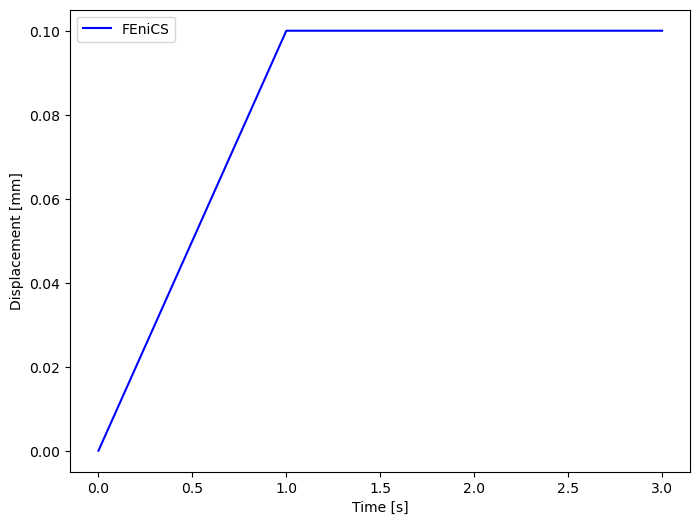

In [21]:
## STRETCH EVOLUTION
f = plt.figure(figsize=(8,6))
plt.plot(Time,  disp_v,'b-',label='FEniCS')

plt.xlabel('Time [s]')
plt.ylabel('Displacement [mm]')
plt.legend()
plt.show()

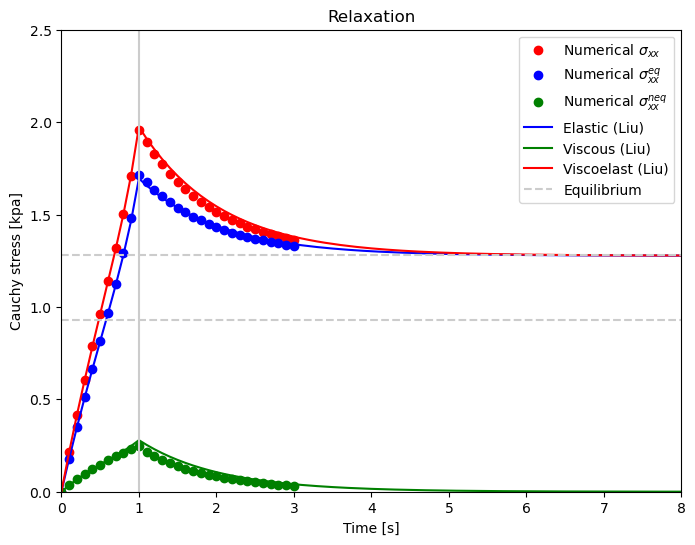

In [22]:
## Stresses
f = plt.figure(figsize=(8,6))

## FEniCSx
plt.plot(Time, SIG_v,'ro',label='Numerical $\sigma_{xx}$')
plt.plot(Time, SIGeq_v,'bo',label='Numerical $\sigma^{eq}_{xx}$')
plt.plot(Time, SIGneq_v,'go',label='Numerical $\sigma^{neq}_{xx}$')

## Liu et al.(2019)
LiuStress = np.loadtxt("data/stress.txt")

plt.plot(LiuStress[:,0], LiuStress[:,1],'b-',label='Elastic (Liu)')
plt.plot(LiuStress[:,0], LiuStress[:,2],'g-',label='Viscous (Liu)')
plt.plot(LiuStress[:,0], LiuStress[:,3],'r-',label='Viscoelast (Liu)')

plt.axhline(y=1.2808, color='0.8', linestyle='--', label = 'Equilibrium') 
plt.axhline(y=0.9293, color='0.8', linestyle='--')
plt.axvline(x = 1, color = '0.8') # Line y = 0

plt.xlabel('Time [s]')
plt.ylabel('Cauchy stress [kpa]')
plt.title('Relaxation')
plt.legend()
plt.axis([0, 8, 0, 2.5])
plt.show()

Text(0.5, 1.0, 'I4e iso')

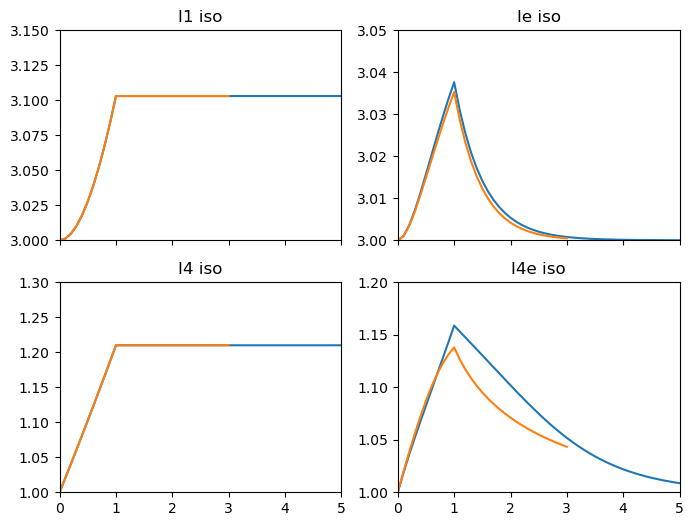

In [23]:
## Invariants

invariantsInfo = np.loadtxt("data/invariants.txt")
Time0  = invariantsInfo[:,0]
I1iso  = invariantsInfo[:,1]
Ieiso  = invariantsInfo[:,2]
I4iso  = invariantsInfo[:,3]
I4eiso = invariantsInfo[:,4]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True,figsize=(8,6))
ax1.plot(Time0, I1iso)
ax1.plot(Time, invariants[:,0])
ax1.axis([0, 5, 3, 3.15])
ax1.set_title('I1 iso')

ax2.plot(Time0, Ieiso)
ax2.plot(Time, invariants[:,1])
ax2.axis([0, 5, 3, 3.05])
ax2.set_title('Ie iso')

ax3.plot(Time0, I4iso)
ax3.plot(Time, invariants[:,2])
ax3.axis([0, 5, 1, 1.3])
ax3.set_title('I4 iso')

ax4.plot(Time0, I4eiso)
ax4.plot(Time, invariants[:,3])
ax4.axis([0, 5, 1, 1.2])
ax4.set_title('I4e iso')